# Comparing distance between dino and clip embeddings

In [1]:
import h5py
import pickle
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, cdist
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA



In [1]:
#TODO add object identifier

In [2]:
def loadJSON(path):
  infile = open(path,'rb')
  X = json.load(infile)
  print('Loaded ' + path.split('/')[-1])
  return X

def pairwise_similarity_between_years(year1, year2, embedding_type):
    embeddings1 = np.array(embeddings_by_year[year1][embedding_type])
    embeddings2 = np.array(embeddings_by_year[year2][embedding_type])
    cosine_distance = cdist(embeddings1, embeddings2, 'cosine')
    cosine_similarity = 1 - cosine_distance
    return np.mean(cosine_similarity)

def calculate_pairwise_cosine_similarity(embeddings):
  '''
  vectorized version of pairwise cosine similarity
  input takes an embedding and calculates among all the pairs
  '''
  norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
  similarity_matrix = np.dot(norm_embeddings, norm_embeddings.T)
  return similarity_matrix

def flatten_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]
  

def compare_similarity_between_years(embedding_type):
  '''
  Calculate similarities between all pairs of years using the entire embedding.
  embedding type can be: dino or clip
  '''
  results = []

  years = sorted(embeddings_by_year.keys())
  for year1, year2 in combinations(years, 2):
      print(year1, year2)
      avg_similarity = pairwise_similarity_between_years(year1, year2, embedding_type)
      results.append({'Year1': year1, 'Year2': year2, 'AverageCosineSimilarity': avg_similarity})

  results_df = pd.DataFrame(results)
  print(results_df)
  results_df.to_csv(f'pair_wise_cosine_similarities_{embedding_type}.csv', index=False)

def fisher_z_transformation(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher_z_transformation(z):
    return (np.exp(2*z) - 1) / (np.exp(2*z) + 1)

def calculate_confidence_interval(r, n, confidence_level=0.95):
    z = fisher_z_transformation(r)
    se_z = 1 / np.sqrt(n - 3)
    z_critical = stats.norm.ppf((1 + confidence_level) / 2)  
    ci_z = z + np.array([-1, 1]) * z_critical * se_z
    ci_r = inverse_fisher_z_transformation(ci_z)
    return ci_r


def discretize_years_to_periods(years, period=5):
    """
    Discretize a list of years into 5-year periods.
    
    Parameters:
    - years: List of years (integers).
    - period: Length of the period in years. Default is 5 years.

                                                                                                                            ``
    Returns:
    - List of period start years corresponding to each input year.
    """
    period_starts = [(year // period) * period for year in years]
    return period_starts

In [4]:
data_folder = 'data/'

# load data

In [5]:
# loading meta-data

image_data = loadJSON(data_folder + 'all_paths_dates.json') # all available data, pre-clipping to the range 1950-1999
dates = np.array(image_data)[:, 1]

# # prepare list of years in data
# years = []
# for i, date in enumerate(dates):
#     year = int(date.split('-')[-1])
#     years.append(year)

print("Loaded " + str(len(image_data)) + " images")

Loaded all_paths_dates.json
Loaded 43039 images


## Loading embeddings

In [6]:
dino_embeddings = h5py.File(data_folder + "dinov2-person-crop-embeddings.h5" ,"r")
clip_embeddings = h5py.File(data_folder + "openclip-person-crop-embeddings.h5", "r")

# convert ids from bytestring to strings
ids = clip_embeddings['id'][:]
ids = [id_.decode('utf-8') for id_ in ids]
labels = clip_embeddings['labels'][:]
labels = [str(label_[0]) for label_ in labels]

# only select years from metadata that also occur in embeddings of persons
year_dict = {}
for path, date in image_data:
    year = int(date.split('-')[-1])
    id_ = path.split('/')[-1]   
    year_dict[id_] = year 


year_list = [year_dict.get(id_) for id_ in ids] 

# construct a dictionary that holds all the embeddings (dino and clip) per year

embeddings_by_year = {}

for year, dino_embedding, clip_embedding in zip(year_list, dino_embeddings['X'], clip_embeddings['X']):
    if year not in embeddings_by_year:
        embeddings_by_year[year] = {'dino': [], 'clip': []}

    embeddings_by_year[year]['dino'].append(dino_embedding)
    embeddings_by_year[year]['clip'].append(clip_embedding)

In [7]:


combined = list(zip(year_list, clip_embeddings['X']))

In [8]:
# Sort the combined list by the date component
combined_sorted = sorted(combined, key=lambda x: x[0])
dates_sorted, embeddings_sorted = zip(*combined_sorted)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

normalized_embeddings = embeddings_sorted / np.linalg.norm(embeddings_sorted, axis=1, keepdims=True)

similarities = cosine_similarity(normalized_embeddings)
consecutive_similarities = similarities[np.arange(len(similarities)-1), np.arange(1, len(similarities))]

# Convert similarities to distances
consecutive_distances = 1 - consecutive_similarities

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(consecutive_distances, marker='o', linestyle='-')
plt.xlabel('Time (index of images)')
plt.ylabel('Pairwise Distance Between Consecutive Embeddings')
plt.title('Temporal Changes in Embeddings')
plt.grid(True)
plt.show()


In [31]:
dino_yearly = np.array([np.mean(embeddings_by_year[year]['dino'], axis=0) for year in sorted(embeddings_by_year)])
clip_yearly = np.array([np.mean(embeddings_by_year[year]['clip'], axis=0) for year in sorted(embeddings_by_year)])

years = np.array(sorted(embeddings_by_year))

pca_dino = PCA(n_components=2)  
reduced_dino_yearly = pca_dino.fit_transform(dino_yearly)

pca_clip = PCA(n_components=2) 
reduced_clip_yearly = pca_clip.fit_transform(clip_yearly)


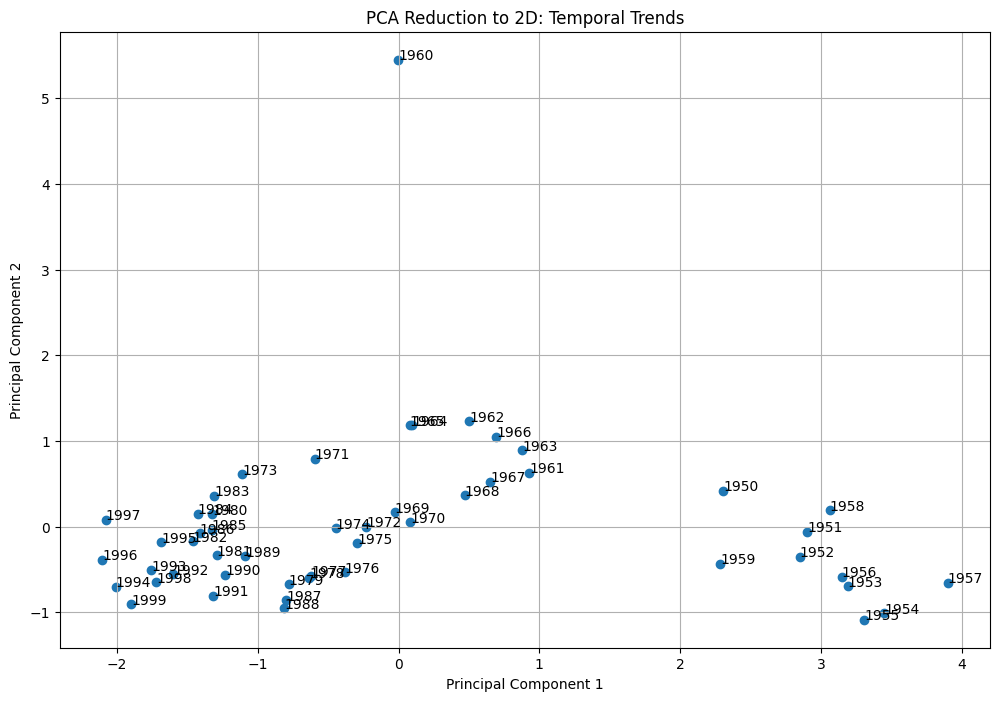

In [39]:
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Scatter plot of the two principal components
plt.scatter(reduced_dino_yearly[:, 0], reduced_dino_yearly[:, 1])

# Annotate each point with its corresponding year
for i, year in enumerate(years):
    plt.annotate(year, (reduced_dino_yearly[i, 0], reduced_dino_yearly[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduction to 2D: Temporal Trends')
plt.grid(True)
plt.show()

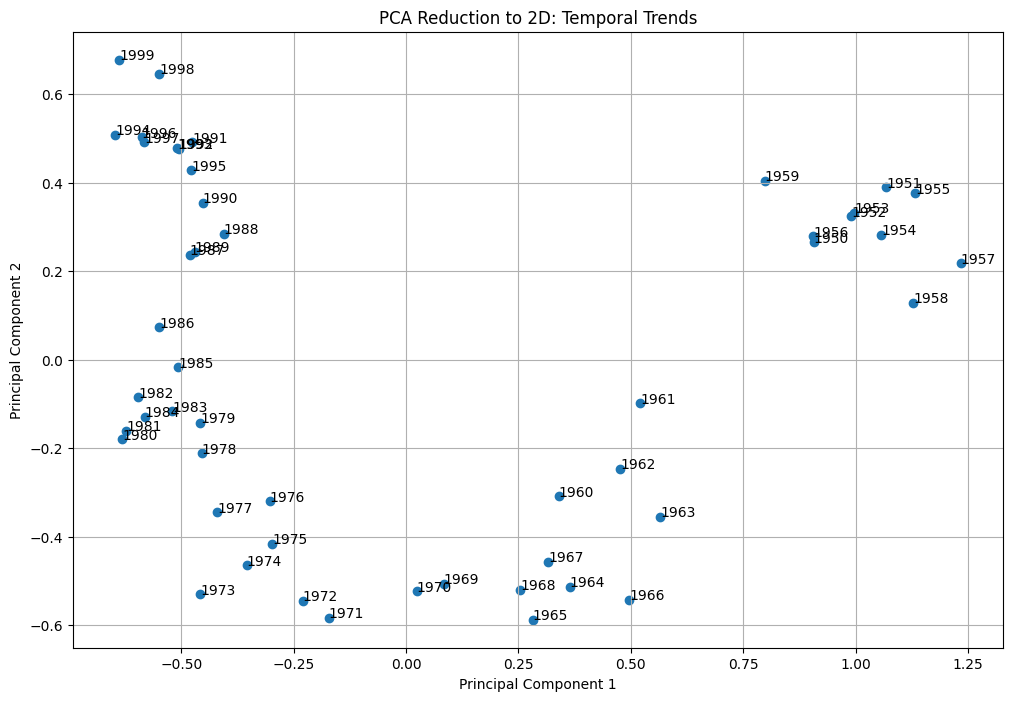

In [33]:
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Scatter plot of the two principal components
plt.scatter(reduced_clip_yearly[:, 0], reduced_clip_yearly[:, 1])

# Annotate each point with its corresponding year
for i, year in enumerate(years):
    plt.annotate(year, (reduced_clip_yearly[i, 0], reduced_clip_yearly[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduction to 2D: Temporal Trends')
plt.grid(True)
plt.show()

In [43]:
pca = PCA(n_components=50)  # Reduce to an intermediate dimension, e.g., 50
pca_result = pca.fit_transform(clip_yearly)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # Adjust parameters as needed
tsne_result = tsne.fit_transform(pca_result)

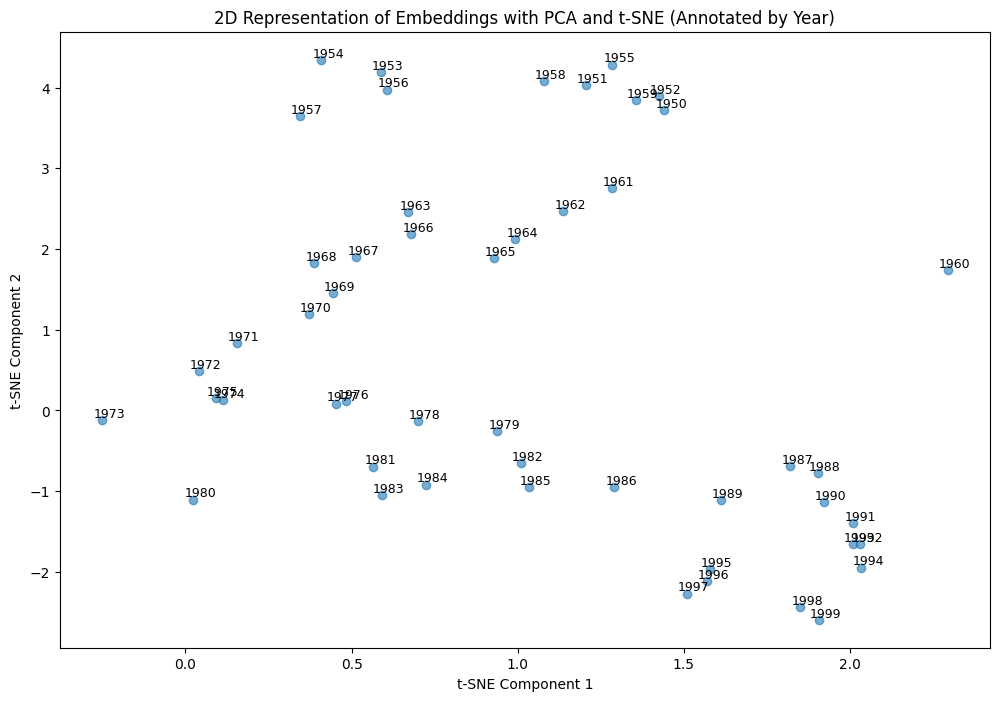

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

# Create a scatter plot of the t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)  # Alpha for better visibility

# Annotate each point with its corresponding year
for i, year in enumerate(years):
    plt.annotate(str(year), (tsne_result[i, 0], tsne_result[i, 1]),
                 textcoords="offset points",  # Position text slightly offset from the point
                 xytext=(5,2),  # Distance from the text to the points (x,y)
                 ha='center',  # Horizontal alignment
                 fontsize=9)  # Font size

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D Representation of Embeddings with PCA and t-SNE (Annotated by Year)')
plt.show()


In [34]:
X = years.reshape(-1, 1)
y = reduced_clip_yearly


from sklearn.linear_model import LinearRegression

# Initialize a list to store models for each dimension
models = []

# Fit a linear regression model for each dimension of the embeddings
for i in range(y.shape[1]):  # Iterate over each dimension
    model = LinearRegression()
    model.fit(X, y[:, i])
    models.append(model)

In [35]:
for i, model in enumerate(models):
    print(f"Dimension {i+1}:")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"R^2 Score: {model.score(X, y[:, i])}\n")

Dimension 1:
Coefficients: [-0.03925559]
Intercept: 77.51015917568897
R^2 Score: 0.8334700444825347

Dimension 2:
Coefficients: [0.00870088]
Intercept: -17.179880619777137
R^2 Score: 0.10254735743770726



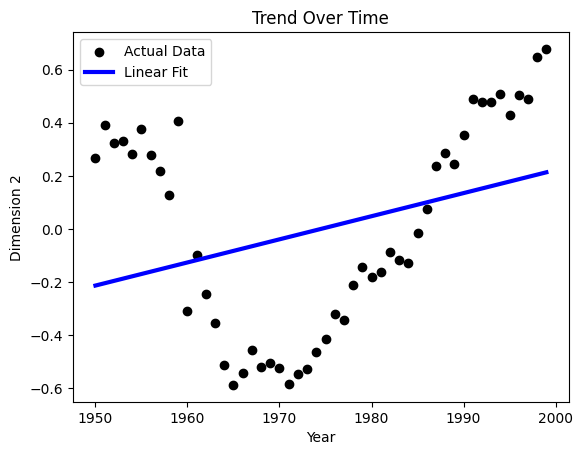

In [38]:
import matplotlib.pyplot as plt

# Choose a dimension to visualize
dimension_idx = 1  # For example, the first dimension

# Scatter plot of the actual data
plt.scatter(X, y[:, dimension_idx], color='black', label='Actual Data')

# Plotting the regression line for the chosen dimension
predicted = models[dimension_idx].predict(X)
plt.plot(X, predicted, color='blue', linewidth=3, label='Linear Fit')

# Optionally, add polynomial fit if you've done polynomial regression
# predicted_poly = poly_models[dimension_idx].predict(X_poly)
# plt.plot(X, predicted_poly, color='red', linewidth=3, label='Polynomial Fit')

plt.xlabel('Year')
plt.ylabel(f'Dimension {dimension_idx + 1}')
plt.title('Trend Over Time')
plt.legend()
plt.show()

In [46]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Initialize a list to store polynomial models for each dimension
poly_models = []

# Fit a polynomial regression model for each dimension of the embeddings
for i in range(y.shape[1]):
    model = LinearRegression()
    model.fit(X_poly, y[:, i])
    poly_models.append(model)

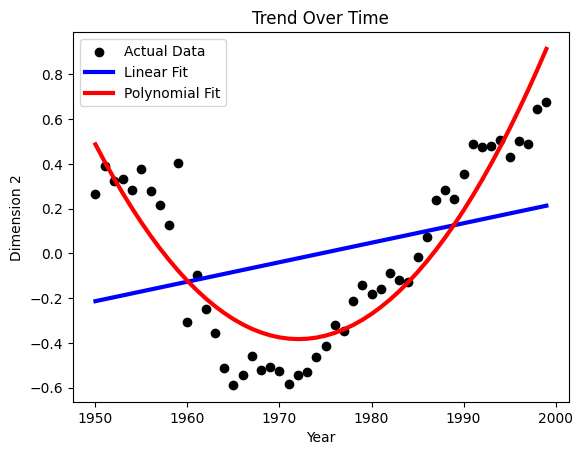

In [50]:
import matplotlib.pyplot as plt

# Choose a dimension to visualize
dimension_idx = 1  # For example, the first dimension

# Scatter plot of the actual data
plt.scatter(X, y[:, dimension_idx], color='black', label='Actual Data')

# Plotting the regression line for the chosen dimension
predicted = models[dimension_idx].predict(X)
plt.plot(X, predicted, color='blue', linewidth=3, label='Linear Fit')

# Optionally, add polynomial fit if you've done polynomial regression
predicted_poly = poly_models[dimension_idx].predict(X_poly)
plt.plot(X, predicted_poly, color='red', linewidth=3, label='Polynomial Fit')

plt.xlabel('Year')
plt.ylabel(f'Dimension {dimension_idx + 1}')
plt.title('Trend Over Time')
plt.legend()
plt.show()


In [ ]:
for i in range(n_components):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(years_sorted, reduced_data[:, i], marker='o', linestyle='-', label=f'PC{i+1}')
    plt.xlabel('Year')
    plt.ylabel(f'Score of Principal Component {i+1}')
    plt.title(f'Temporal Trend of Principal Component {i+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'embeddings' is a list or array of your embeddings, ordered by time
# Convert embeddings to a normalized form if they are not already normalized
# Normalize embeddings to ensure cosine similarity works correctly
normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Compute cosine similarities between consecutive embeddings
# Note: cosine_similarity returns a matrix, we are interested in the off-diagonal elements that represent consecutive comparisons
similarities = cosine_similarity(normalized_embeddings)
consecutive_similarities = similarities[np.arange(len(similarities)-1), np.arange(1, len(similarities))]

# Convert similarities to distances
consecutive_distances = 1 - consecutive_similarities


# Step 1
Compare the embeddings of 1 year to all the other years. We increase the distance between year 1 and year 2. 
We do this both for the clip and the dino embeddings.

In [17]:
for embedding_type in ['dino', 'clip']:
    compare_similarity_between_years(embedding_type)


1950 1951
1950 1952
1950 1953
1950 1954
1950 1955
1950 1956
1950 1957
1950 1958
1950 1959
1950 1960
1950 1961
1950 1962
1950 1963
1950 1964
1950 1965
1950 1966
1950 1967
1950 1968
1950 1969
1950 1970
1950 1971
1950 1972
1950 1973
1950 1974
1950 1975
1950 1976
1950 1977
1950 1978
1950 1979
1950 1980
1950 1981
1950 1982
1950 1983
1950 1984
1950 1985
1950 1986
1950 1987
1950 1988
1950 1989
1950 1990
1950 1991
1950 1992
1950 1993
1950 1994
1950 1995
1950 1996
1950 1997
1950 1998
1950 1999
1951 1952
1951 1953
1951 1954
1951 1955
1951 1956
1951 1957
1951 1958
1951 1959
1951 1960
1951 1961
1951 1962
1951 1963
1951 1964
1951 1965
1951 1966
1951 1967
1951 1968
1951 1969
1951 1970
1951 1971
1951 1972
1951 1973
1951 1974
1951 1975
1951 1976
1951 1977
1951 1978
1951 1979
1951 1980
1951 1981
1951 1982
1951 1983
1951 1984
1951 1985
1951 1986
1951 1987
1951 1988
1951 1989
1951 1990
1951 1991
1951 1992
1951 1993
1951 1994
1951 1995
1951 1996
1951 1997
1951 1998
1951 1999
1952 1953
1952 1954
1952 1955


In [27]:

# clip_between_years = pd.read_csv('pair_wise_cosine_similarities_clip.csv')
# dino_between_years = pd.read_csv('pair_wise_cosine_similarities_dino.csv')


def plot_between_years(embedding_type):
    df = pd.read_csv(f'pair_wise_cosine_similarities_{embedding_type}.csv')
    df['Year1'] = df['Year1'].astype(str)
    df['Year2'] = df['Year2'].astype(str)
    similarity_matrix = df.pivot(index='Year1', columns='Year2', values='AverageCosineSimilarity')
    plot_heatmap(similarity_matrix, embedding_type)

def plot_heatmap(similarity_matrix, embedding_type, xlabel='year2', ylabel='year1', title='Yearly Pairwise Similarities'):

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap="viridis", annot=False, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f'Yearly Pairwise Cosine Similarities of {embedding_type}', pad=20)
    plt.xlabel('Year2')
    plt.ylabel('Year1')
    plt.xticks(rotation=45)
    plt.show();


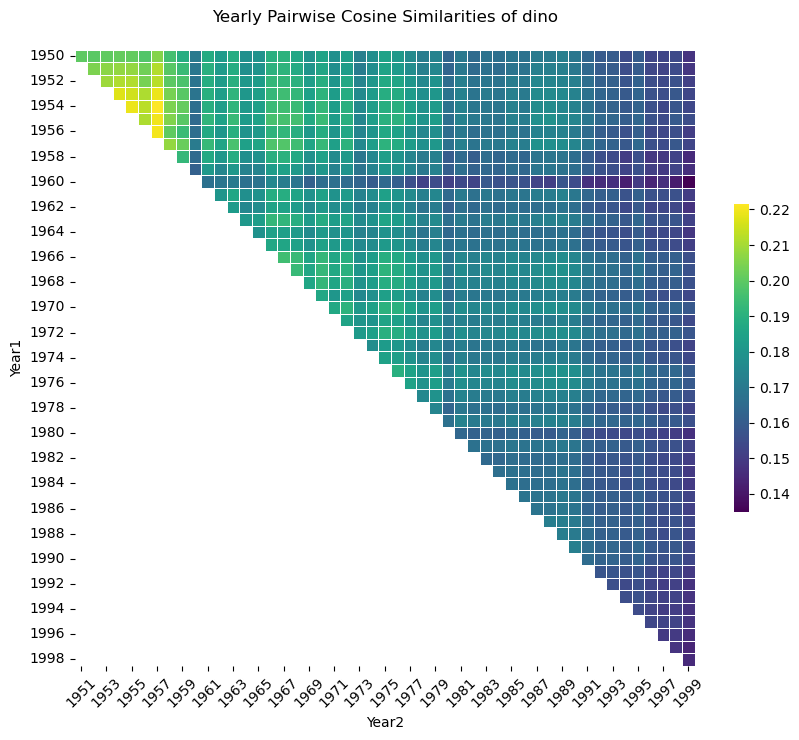

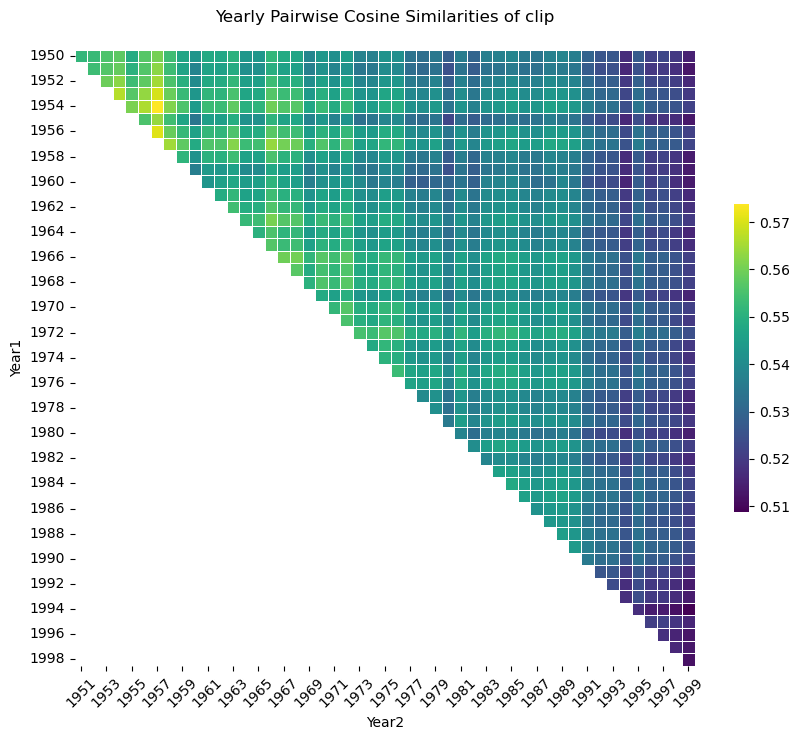

In [28]:
plot_between_years('dino')
plot_between_years('clip')


## Step 2. Calculating Correlation between CLIP and DINO within year

In [29]:
if not os.path.exists('correlations_data.pkl'):
    correlations = {}
    for year, embeddings_dict in tqdm(embeddings_by_year.items(), desc="Calculating correlations"):
            dino_similarity_matrix = calculate_pairwise_cosine_similarity(embeddings_dict['dino'])
            clip_similarity_matrix = calculate_pairwise_cosine_similarity(embeddings_dict['clip'])

            if dino_similarity_matrix is not None and clip_similarity_matrix is not None:
                dino_similarities = flatten_upper_triangle(dino_similarity_matrix)
                clip_similarities = flatten_upper_triangle(clip_similarity_matrix)
                
                num_observations = len(dino_similarities)
                
                pearson_corr, _ = pearsonr(dino_similarities, clip_similarities)
                spearman_corr, _ = spearmanr(dino_similarities, clip_similarities)
                
                correlations[year] = {'pearson': pearson_corr, 'spearman': spearman_corr, 'n_observations': num_observations}
            else:
                correlations[year] = {'pearson': np.nan, 'spearman': np.nan, 'n_observations': 0} 

        
    with open('correlations_data.pkl', 'wb') as file:
        pickle.dump(correlations, file)

else:
    with open('correlations_data.pkl', 'rb') as file:
        correlations = pickle.load(file)
    print("'correlations_data.pkl' was found and data has been loaded.")

'correlations_data.pkl' was found and data has been loaded.


In [36]:
sorted_years = sorted(list(correlations.keys()))



Spearman Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     18.38
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           8.68e-05
Time:                        12:13:41   Log-Likelihood:                 107.29
No. Observations:                  50   AIC:                            -210.6
Df Residuals:                      48   BIC:                            -206.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9486      0.559     

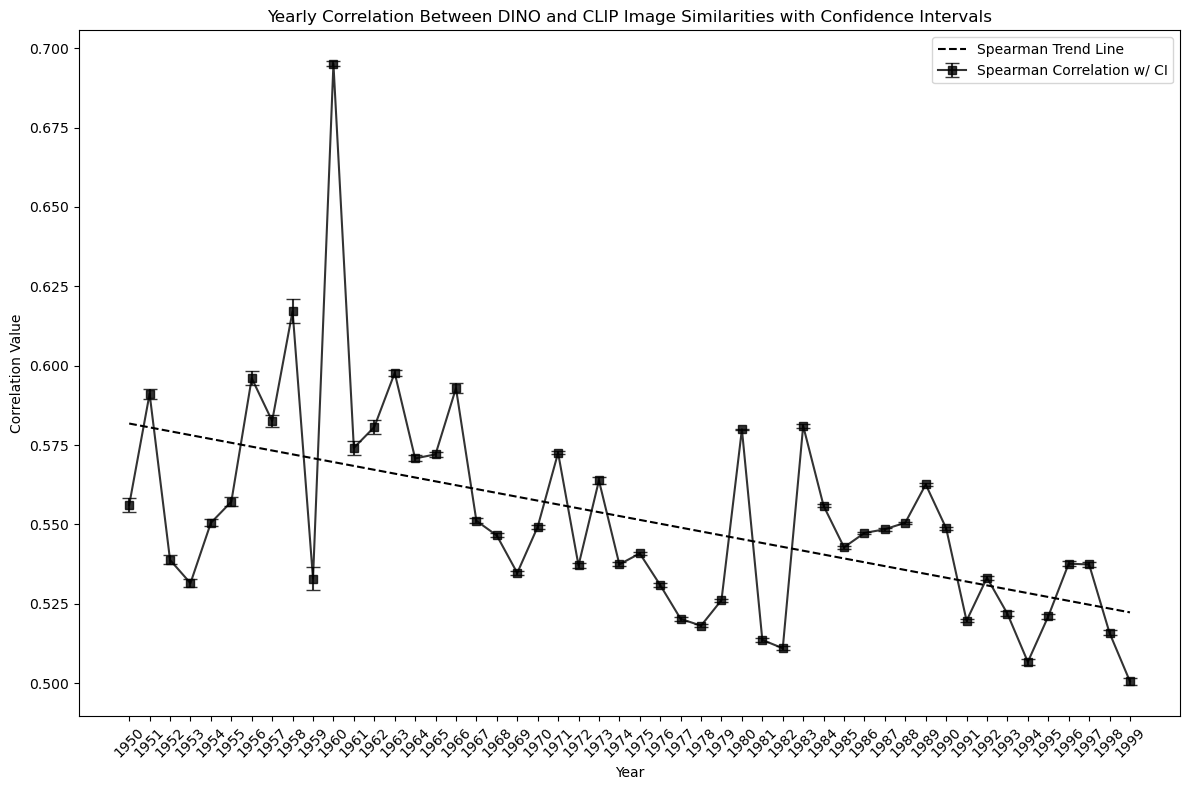

In [41]:
def extract_values(correlations, key):
    '''
    Function to extract values from correlations dictionary
    '''
    return [correlations[year][key] for year in sorted(correlations)]

def calculate_error_bars(values, confidence_intervals):
    '''
    Function to calculate error bars based on confidence intervals
    '''
    lower_limits, upper_limits = zip(*confidence_intervals)
    lower_errors = np.array(values) - np.array(lower_limits)
    upper_errors = np.array(upper_limits) - np.array(values)
    return [lower_errors, upper_errors]

sorted_correlations = {k: correlations[k] for k in sorted(correlations)}
# Extracting sorted values from the correlations dictionary
sorted_years = list(sorted_correlations.keys())
#pearson_values = extract_values(correlations, 'pearson')
spearman_values = extract_values(sorted_correlations, 'spearman')
n_observations = extract_values(sorted_correlations, 'n_observations')

# Calculating confidence intervals
#pearson_confidence_intervals = [calculate_confidence_interval(r, n) for r, n in zip(pearson_values, n_observations)]
spearman_confidence_intervals = [calculate_confidence_interval(r, n) for r, n in zip(spearman_values, n_observations)]

# Calculating error bars
#pearson_errors = calculate_error_bars(pearson_values, pearson_confidence_intervals)
spearman_errors = calculate_error_bars(spearman_values, spearman_confidence_intervals)


# fit a linear regression for correlation values
numerical_years = np.array(sorted_years).astype(float) 

#pearson_coeffs = np.polyfit(numerical_years, sorted_pearson_values, 1)
#pearson_trendline = np.polyval(pearson_coeffs, numerical_years)

spearman_coeffs = np.polyfit(numerical_years, spearman_values, 1)
spearman_trendline = np.polyval(spearman_coeffs, numerical_years)


# Model Summary Spearman
X = sm.add_constant(sorted_years)
Y = spearman_values

model = sm.OLS(Y, X).fit()
print('Spearman Model')
print(model.summary())


# Plotting
plt.figure(figsize=(12, 8))
#plt.errorbar(sorted_years, pearson_values, yerr=pearson_errors, fmt='-o', capsize=5, label='Pearson Correlation w/ CI', color='blue')
plt.errorbar(sorted_years, spearman_values, yerr=spearman_errors, fmt='-s', capsize=5, label='Spearman Correlation w/ CI', color='black', alpha=.8)
#plt.plot(sorted_years, pearson_trendline, label='Pearson Trend Line', color='blue', linestyle='--')
plt.plot(sorted_years, spearman_trendline, label='Spearman Trend Line', color='black', linestyle='--')

plt.title('Yearly Correlation Between DINO and CLIP Image Similarities with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Correlation Value')
plt.xticks(sorted_years, rotation=45)  # Use sorted years for the x-axis
plt.legend()
plt.tight_layout()
plt.savefig('correlations_with_trendline.png', dpi=300)
plt.show()

### (Hierarchical) Clustering

In [43]:
discretized_periods = discretize_years_to_periods(year_list, 5)


In [55]:

import sklearn
from sklearn.decomposition import PCA

In [62]:
def sample_and_sort_embeds(embedding_type, labels, n_components=50, n_samples=10000):
    # Resample your embeddings and corresponding years/labels
    embeds = None
    
    if embedding_type == 'dino':
        embeds = np.array(dino_embeddings['X'])
    elif embedding_type == 'clip':
        embeds = np.array(clip_embeddings['X'])
    else:
        print('use either clip or dino as embedding')
        return None, None 
    
    sampled_embeddings, sampled_labels = sklearn.utils.resample(embeds, labels, n_samples=n_samples, random_state=42)

    pca = PCA(n_components=n_components) 
    reduced_clip_embeddings = pca.fit_transform(sampled_embeddings)

    # Compute the similarity matrix on reduced embeddings
    similarity_matrix = calculate_pairwise_cosine_similarity(reduced_clip_embeddings)
    # Assuming `embeddings` is your numpy array of CLIP embeddings
    similarity_matrix_pca = calculate_pairwise_cosine_similarity(sampled_embeddings)

    sorted_indices = np.argsort(sampled_labels)
    sorted_similarity_matrix = similarity_matrix[sorted_indices, :][:, sorted_indices]
    sorted_similarity_matrix_pca = similarity_matrix_pca[sorted_indices, :][:, sorted_indices]
    return sorted_similarity_matrix, sorted_similarity_matrix_pca

In [63]:
dino_sampled, dino_sampled_pca = sample_and_sort_embeds('dino', year_list)
clip_sampled, clip_sampled_pca = sample_and_sort_embeds('clip', year_list)



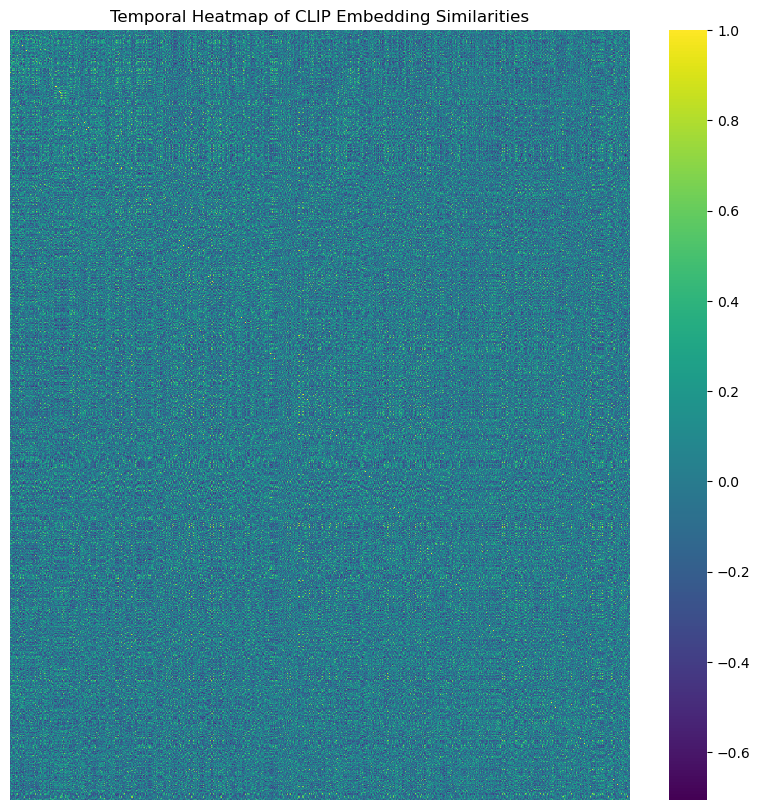

In [64]:
plt.figure(figsize=(10, 10))
sns.heatmap(dino_sampled, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Temporal Heatmap of DINO Embedding Similarities')
plt.show()

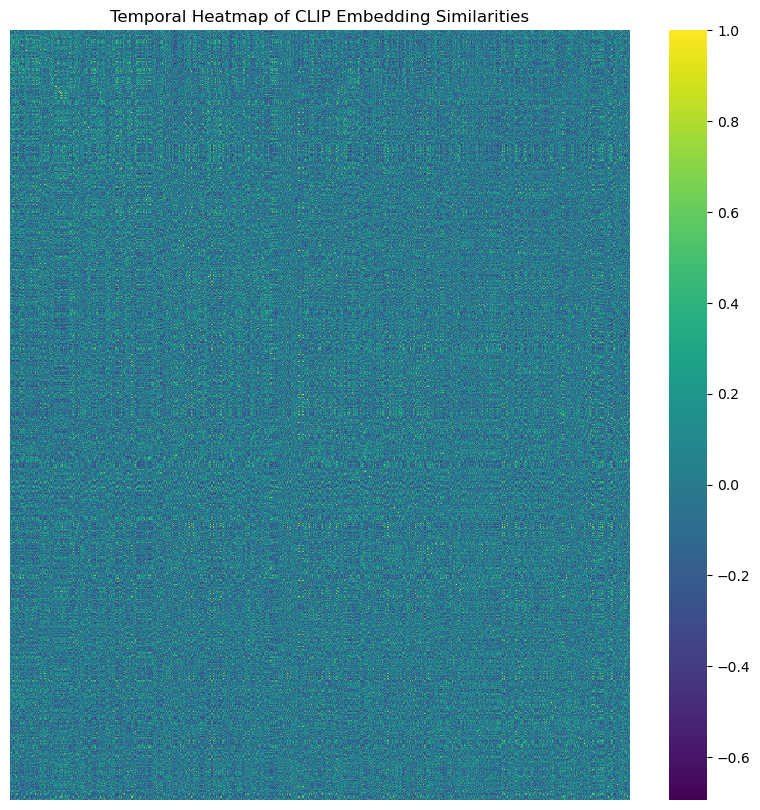

In [66]:
plt.figure(figsize=(10, 10))
sns.heatmap(clip_sampled, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Temporal Heatmap of CLIP Embedding Similarities')
plt.show()

#### Similarity Matrix Using Average Embedding Per Year

In [68]:
# todo replace own function with this
from sklearn.metrics.pairwise import cosine_similarity


def compute_average_embeddings(embeddings_by_year):
    average_embeddings = {'clip': [], 'dino': []}
    
    # Sorted years for consistent ordering
    years = sorted(embeddings_by_year.keys())

    # Compute average embeddings for each year and embedding type
    for year in years:
        for embed_type in ['clip', 'dino']:
            average_embeddings[embed_type].append(np.mean(embeddings_by_year[year][embed_type], axis=0))

    return average_embeddings, years


def compute_similarity_matrices(average_embeddings):
    clip_average_embeddings_matrix = np.array(average_embeddings['clip'])
    dino_average_embeddings_matrix = np.array(average_embeddings['dino'])

    # Compute cosine similarity matrices
    clip_similarity_matrix = cosine_similarity(clip_average_embeddings_matrix)
    dino_similarity_matrix = cosine_similarity(dino_average_embeddings_matrix)

    return clip_similarity_matrix, dino_similarity_matrix

average_embeddings, years = compute_average_embeddings(embeddings_by_year)
clip_similarity_matrix, dino_similarity_matrix = compute_similarity_matrices(average_embeddings)



In [69]:

diff_similarity_matrix = clip_similarity_matrix-dino_similarity_matrix

clip_similarity_df = pd.DataFrame(clip_similarity_matrix, index=years, columns=years)
dino_similarity_df = pd.DataFrame(dino_similarity_matrix, index=years, columns=years)
diff_similarity_df = pd.DataFrame(diff_similarity_matrix, index=years, columns=years)


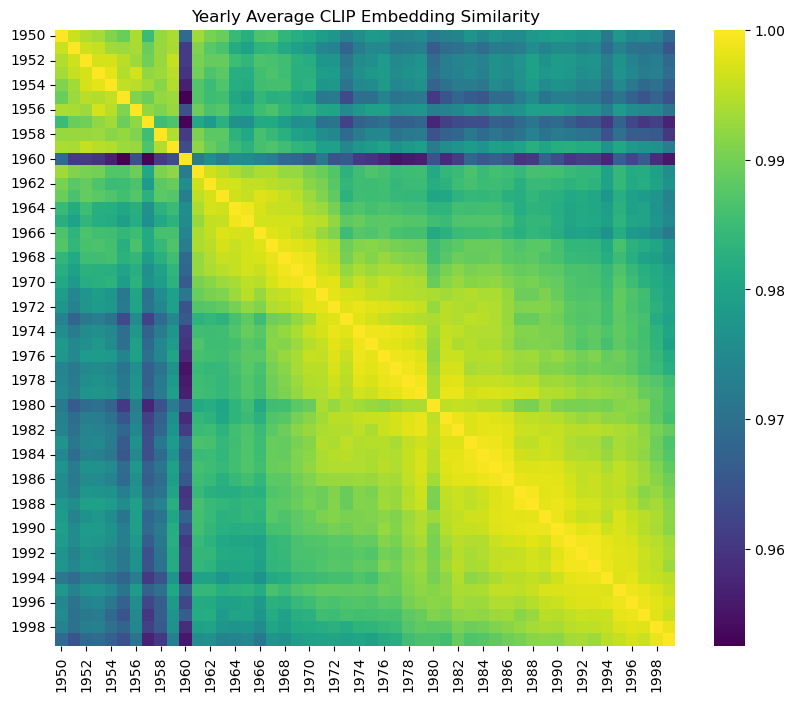

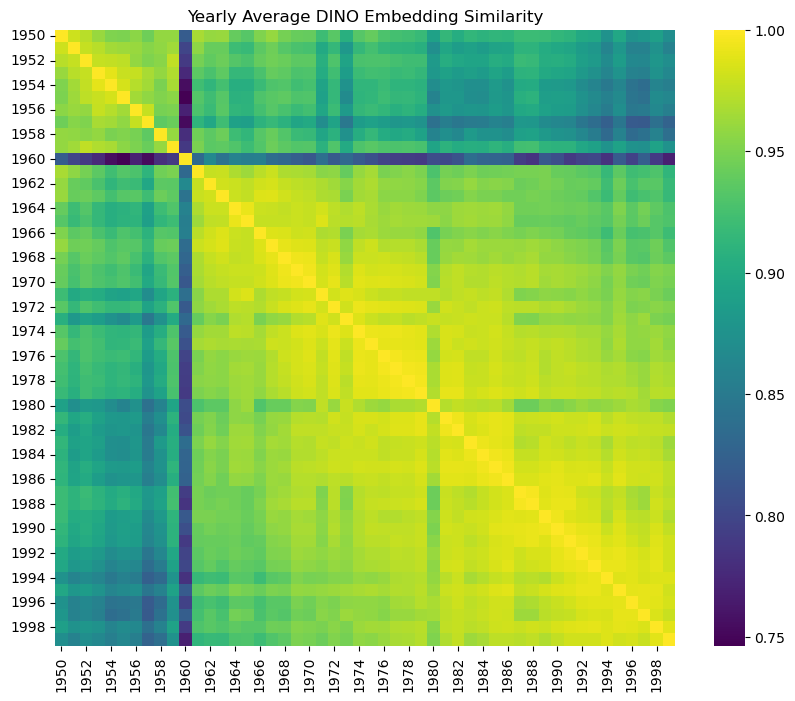

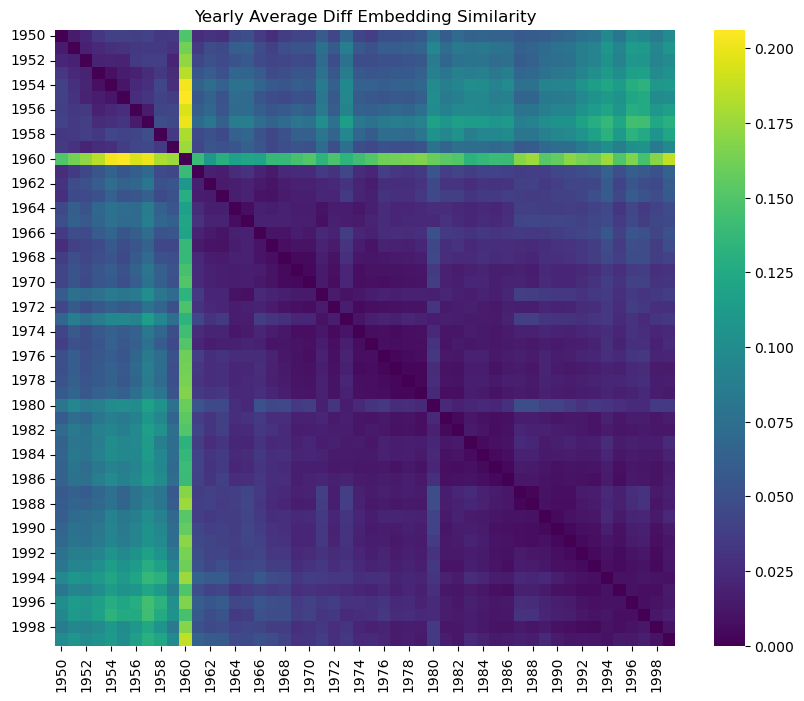

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot similarity heatmap
def plot_similarity_heatmap(similarity_df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, cmap='viridis', annot=False, fmt=".3f")
    plt.title(title)
    plt.show()


# Plot heatmaps for CLIP and DINO
plot_similarity_heatmap(clip_similarity_df, "Yearly Average CLIP Embedding Similarity")
plot_similarity_heatmap(dino_similarity_df, "Yearly Average DINO Embedding Similarity")
plot_similarity_heatmap(diff_similarity_df, "Yearly Average Diff Embedding Similarity")


In [71]:
pearsonr(clip_similarity_matrix.flatten(), dino_similarity_matrix.flatten())

PearsonRResult(statistic=0.9435247607982788, pvalue=0.0)

The matrices are very strongly correlated, so basically the same. 

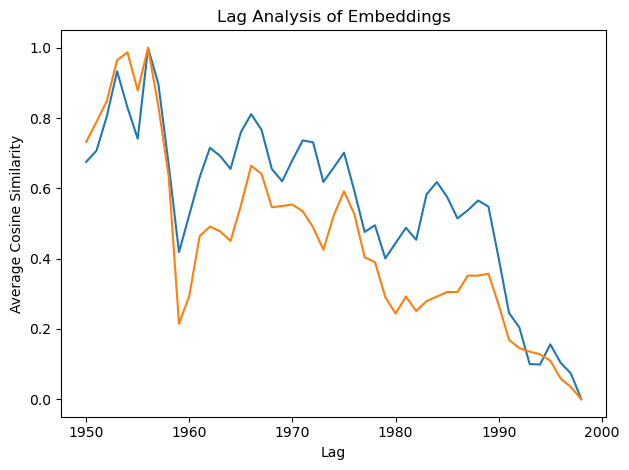

In [85]:
embedding_types = ['clip', 'dino']
lag_similarities = {embedding_type: {} for embedding_type in embedding_types}

for embedding_type in embedding_types:
    for year in range(years[0], years[-1]):  # 'years' is a sorted list of unique years in your dataset
        if year + 2 not in embeddings_by_year:  # Check if the next year is in the dataset
            continue

        current_year_images = embeddings_by_year[year][embedding_type]
        next_year_images = embeddings_by_year[year + 1][embedding_type]
        #lag = year - years[0]  # Adjusted lag calculation to start from 0
        
        # Calculate pairwise similarities between current year and next year images
        similarities = cosine_similarity(current_year_images, next_year_images)
        lag_similarities[embedding_type][year] = np.mean(similarities)

# Plotting side by side
fig, ax = plt.subplots()
normalized = True
for i, embedding_type in enumerate(embedding_types):
    y = list(lag_similarities[embedding_type].values())
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))
    if normalized:
        ax.plot(list(lag_similarities[embedding_type].keys()), y_normalized)
    else:
        ax.plot(list(lag_similarities[embedding_type].keys()), y)
ax.set_xlabel('Lag')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title(f'Lag Analysis of Embeddings')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


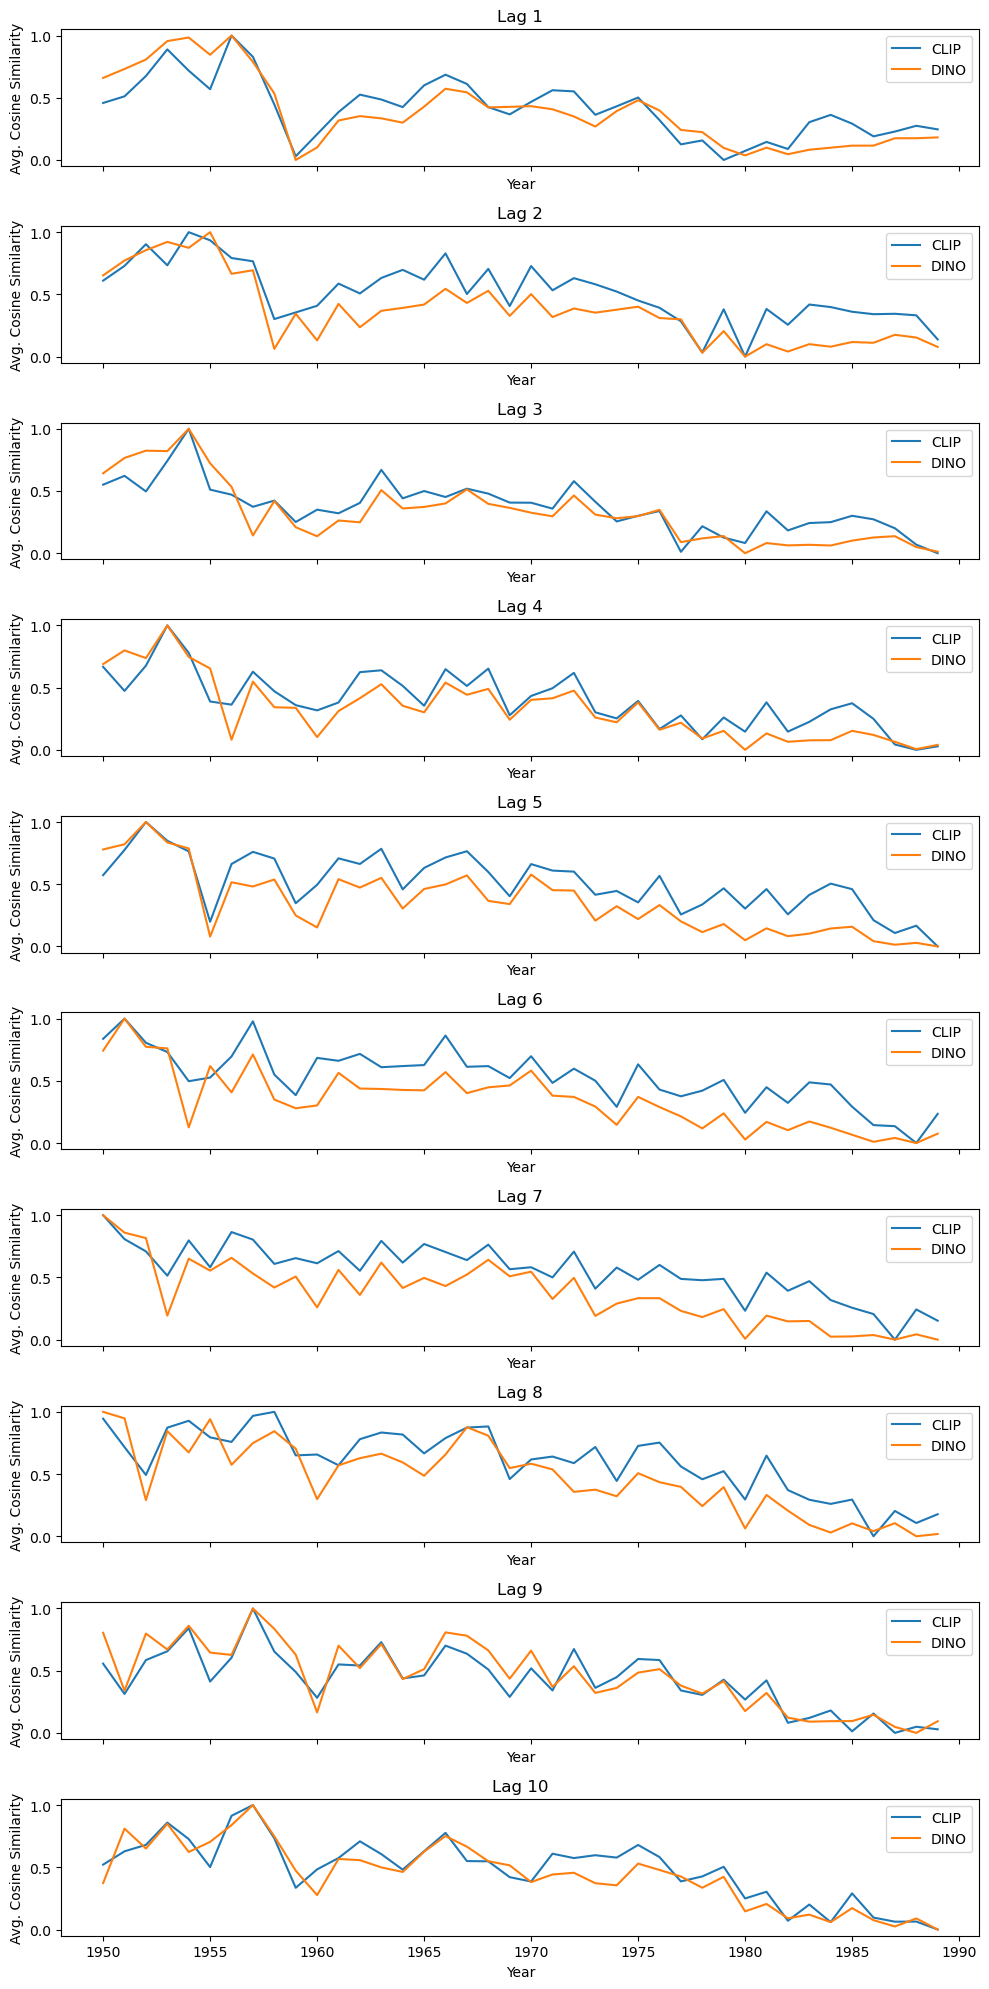

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming max_lag and lag_similarities are defined as in the previous example
max_lag = 10  # Example max lag

# Plotting in a single column grid, each lag on a separate subplot
fig, axs = plt.subplots(max_lag, 1, figsize=(10, 20), sharex=True)

for lag in range(1, max_lag + 1):
    ax = axs[lag - 1]  # Select the appropriate subplot
    
    for embedding_type in embedding_types:
        y = lag_similarities[embedding_type][lag]
        
        # Check if normalization is required
        if normalized:
            y = (y - np.min(y)) / (np.max(y) - np.min(y))
        
        ax.plot(range(years[0], years[0] + len(y)), y, label=f'{embedding_type.upper()}')

    ax.set_title(f'Lag {lag}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Avg. Cosine Similarity')
    ax.legend()

plt.tight_layout()
plt.show()


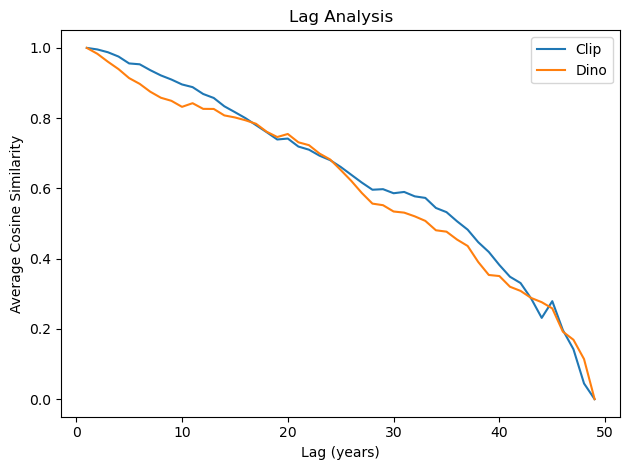

In [84]:
embedding_types = ['clip', 'dino']
lag_similarities = {embedding_type: {} for embedding_type in embedding_types}

for embedding_type in embedding_types:
    for start_year in range(years[0], years[-1]):
        for lag in range(1, (years[-1] - start_year) + 1):  # Iterate through all possible lags
            if (start_year + lag) not in embeddings_by_year:  # Check if the lagged year is in the dataset
                continue

            current_year_images = embeddings_by_year[start_year][embedding_type]
            lagged_year_images = embeddings_by_year[start_year + lag][embedding_type]
            
            # Calculate pairwise similarities between current year and lagged year images
            similarities = cosine_similarity(current_year_images, lagged_year_images)
            if lag not in lag_similarities[embedding_type]:
                lag_similarities[embedding_type][lag] = []
            lag_similarities[embedding_type][lag].append(np.mean(similarities))

# Averaging the similarities for each lag across all start years
for embedding_type in embedding_types:
    for lag in lag_similarities[embedding_type]:
        lag_similarities[embedding_type][lag] = np.mean(lag_similarities[embedding_type][lag])

# Plotting
fig, ax = plt.subplots()  # 1 row, 2 columns for 'clip' and 'dino'

for i, embedding_type in enumerate(embedding_types):
    lags = list(lag_similarities[embedding_type].keys())
    avg_similarities = list(lag_similarities[embedding_type].values())
    
    # Normalizing if required
    if normalized:
        avg_similarities = (avg_similarities - np.min(avg_similarities)) / (np.max(avg_similarities) - np.min(avg_similarities))
    
    ax.plot(lags, avg_similarities, label=embedding_type.capitalize())
ax.set_xlabel('Lag (years)')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title(f'Lag Analysis')
ax.legend()

plt.tight_layout()
plt.show()


high correlation persists at higher lag. So more auto-correlation, more temporal information encoded in CLIP??

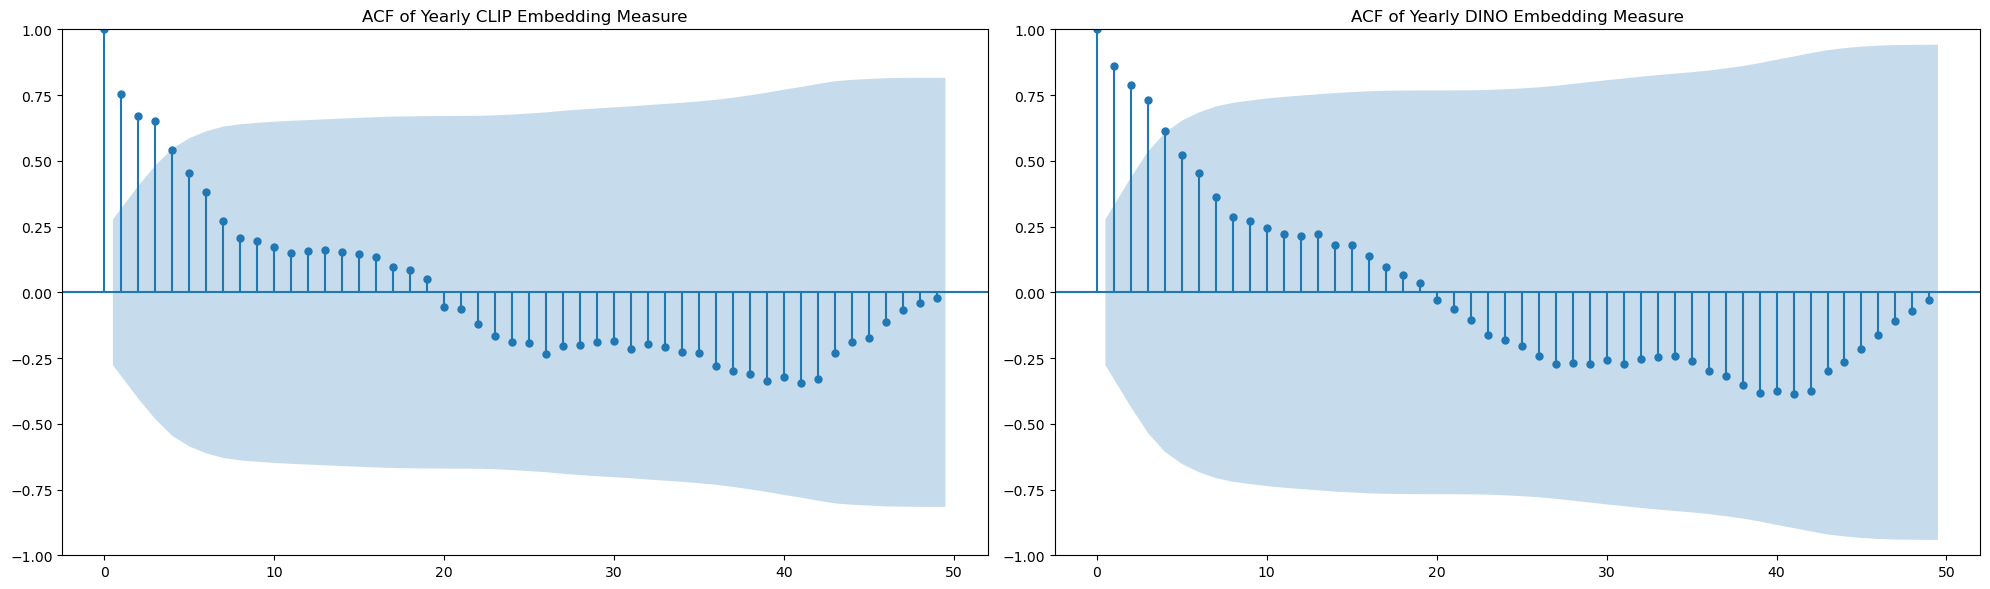

In [115]:
embedding_types = ['clip', 'dino']
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

for i, embedding_type in enumerate(embedding_types):
    yearly_measure = {}

    for year, embeddings in embeddings_by_year.items():
        # Calculate pairwise cosine similarity for the embedding type and then take the average
        similarity_matrix = calculate_pairwise_cosine_similarity(embeddings[embedding_type])
        avg_similarity = np.mean(similarity_matrix)
        yearly_measure[year] = avg_similarity

    # Ensure the years are sorted and create the time series list
    sorted_years = sorted(yearly_measure.keys())
    time_series = [yearly_measure[year] for year in sorted_years]

    # Generate the ACF plot for the current embedding type
    plot_acf(time_series, ax=axs[i], lags=len(time_series)-1, title=f'ACF of Yearly {embedding_type.upper()} Embedding Measure')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


### prototypes

In [146]:
from collections import defaultdict

period_list = []
period_embeddings = defaultdict(list)
period_images = defaultdict(list)
for embedding, year, image_id, object_label in zip(clip_embeddings['X'], year_list, ids, labels): 
    period = (year // 5) * 5  # Determine the 5-year period
    name, extension = image_id.rsplit('.', 1)
    modified_id = f'{name}_obj_{object_label}.{extension}'
    period_list.append(period)
    period_embeddings[period].append(embedding)
    period_images[period].append(modified_id)

In [147]:
period_images[1970]

['NL-HlmNHA_1478_10631K00_01_obj_4.jpg',
 'NL-HlmNHA_1478_11697K00_10_obj_5.jpg',
 'NL-HlmNHA_1478_10598K00_03_obj_0.jpg',
 'NL-HlmNHA_1478_10386K00_07_obj_5.jpg',
 'NL-HlmNHA_1478_13483K00_20_obj_14.jpg',
 'NL-HlmNHA_1478_13362K00_16_obj_2.jpg',
 'NL-HlmNHA_1478_10281K00_28_obj_2.jpg',
 'NL-HlmNHA_1478_10232K02_01_obj_7.jpg',
 'NL-HlmNHA_1478_10830K00_31_obj_0.jpg',
 'NL-HlmNHA_1478_12950K00_19_obj_0.jpg',
 'NL-HlmNHA_1478_13332K00_11_obj_0.jpg',
 'NL-HlmNHA_1478_12346K00_29_obj_3.jpg',
 'NL-HlmNHA_1478_09744K00_04_obj_0.jpg',
 'NL-HlmNHA_1478_11849K01_12_obj_8.jpg',
 'NL-HlmNHA_1478_10546K00_37_obj_3.jpg',
 'NL-HlmNHA_1478_13137K00_18_obj_4.jpg',
 'NL-HlmNHA_1478_09983K00_33_obj_1.jpg',
 'NL-HlmNHA_1478_11697K00_02_obj_3.jpg',
 'NL-HlmNHA_1478_12584K00_28_obj_0.jpg',
 'NL-HlmNHA_1478_12476K00_07_obj_9.jpg',
 'NL-HlmNHA_1478_08046K00_20_obj_0.jpg',
 'NL-HlmNHA_1478_13448K00_05_obj_0.jpg',
 'NL-HlmNHA_1478_08290K00_25_obj_7.jpg',
 'NL-HlmNHA_1478_10835K00_09_obj_2.jpg',
 'NL-HlmNHA_147

In [104]:
period_prototypes = {}
for period, embeddings in period_embeddings.items():
    mean_embedding = np.mean(embeddings, axis=0)
    distances = np.linalg.norm(embeddings - mean_embedding, axis=1)
    
    # Get indices of the 10 closest images
    prototypical_indices = np.argsort(distances)[:10]
    
    # Select the 10 closest images based on the indices
    closest_images = [period_images[period][idx] for idx in prototypical_indices]
    
    period_prototypes[period] = closest_images


In [247]:
period_prototypes

{1985: ['NL-HlmNHA_1478_29317K00_29.jpg',
  'NL-HlmNHA_1478_31391K00_07.jpg',
  'NL-HlmNHA_1478_29069K01_20.jpg',
  'NL-HlmNHA_1478_27830K00_40.jpg',
  'NL-HlmNHA_1478_29586K00_21.jpg',
  'NL-HlmNHA_1478_29954K00_37.jpg',
  'NL-HlmNHA_1478_30575K00_25.jpg',
  'NL-HlmNHA_1478_29069K01_20.jpg',
  'NL-HlmNHA_1478_25986K00_13.jpg',
  'NL-HlmNHA_1478_25360K01_11.jpg'],
 1965: ['NL-HlmNHA_1478_03449K00_12.jpg',
  'NL-HlmNHA_1478_06331K00_11.jpg',
  'NL-HlmNHA_1478_NN064K00_05.jpg',
  'NL-HlmNHA_1478_03284K00_17.jpg',
  'NL-HlmNHA_1478_06087K00_20.jpg',
  'NL-HlmNHA_1478_05295K02_16.jpg',
  'NL-HlmNHA_1478_02297A00_12.jpg',
  'NL-HlmNHA_1478_06429K00_34.jpg',
  'NL-HlmNHA_1478_06166K00_05.jpg',
  'NL-HlmNHA_1478_07330K00_37.jpg'],
 1995: ['NL-HlmNHA_1478_46039K00_13.jpg',
  'NL-HlmNHA_1478_45466K00_25.jpg',
  'NL-HlmNHA_1478_47755K00_15.jpg',
  'NL-HlmNHA_1478_42344K00_25.jpg',
  'NL-HlmNHA_1478_46815K00_38.jpg',
  'NL-HlmNHA_1478_44108K00_31.jpg',
  'NL-HlmNHA_1478_45082K00_02.jpg',
  'NL-Hl

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


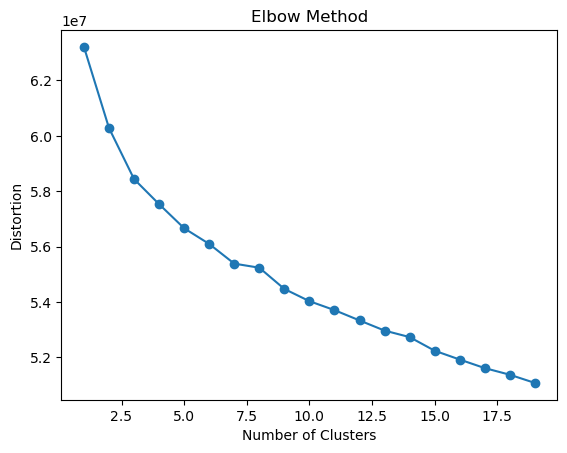

In [144]:
distortions = []
for i in range(1, 20):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(dino_embeds)
    distortions.append(kmeans.inertia_)  # inertia_ represents the sum of squared distances to the closest centroid

plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [145]:
### compare to kmeans clustering

from sklearn.cluster import KMeans

# Example using KMeans, adjust 'n_clusters' as needed
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(dino_embeds)

In [146]:
import pandas as pd

# Assuming 'image_years' is a list/array of years corresponding to each image in the same order as 'all_embeddings'
df = pd.DataFrame({'period': period_list, 'cluster': clusters})
cluster_temporal_distribution = df.groupby('cluster')['period'].value_counts().unstack(fill_value=0)


In [147]:
cluster_temporal_distribution

period   1950  1955  1960  1965  1970  1975  1980  1985  1990  1995
cluster                                                            
0        1046   641   870  2176  2942  3915  4155  4475  3012  2175
1        1677  1254  1265  2362  2634  3735  3018  3720  2158  1590
2         182    78  1091  1309  1972  1954  3370  2212  1358  1385
3        2249  1315  2421  3687  3917  5193  6051  7358  4257  3379
4        1475   801  1633  2257  2811  4167  5387  7147  4997  4092

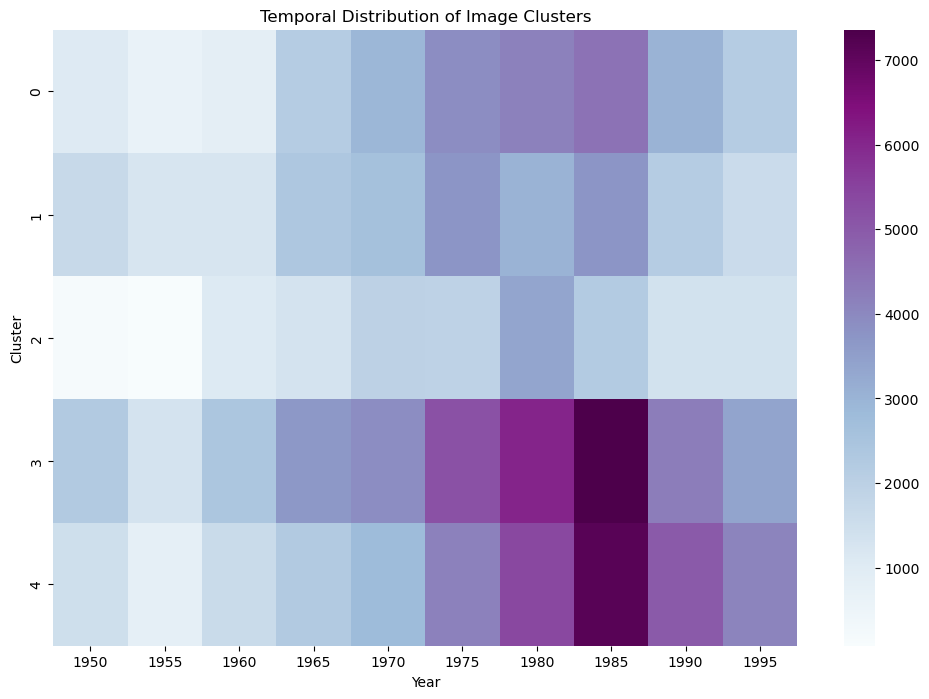

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_temporal_distribution, annot=False, fmt="d", cmap="BuPu")
plt.title("Temporal Distribution of Image Clusters")
plt.ylabel("Cluster")
plt.xlabel("Year")
plt.show()


In [241]:
pca = PCA(n_components=10) 
reduced_clip_embeddings = pca.fit_transform(clip_embeds)

In [ ]:
###hiearchical clustering

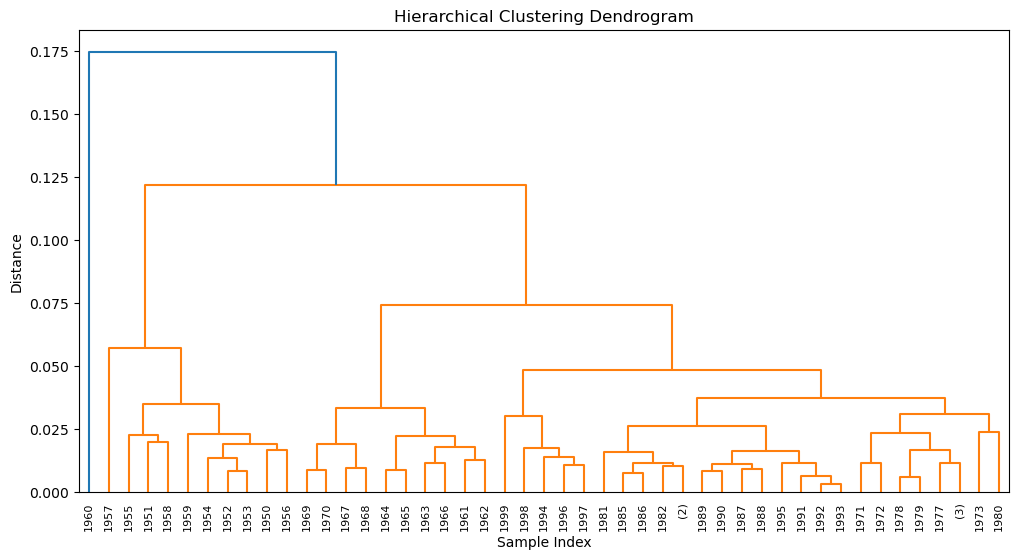

In [217]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

threshold = 8


Z = linkage(clip_similarity_matrix, method='average', metric='euclidean')

# Step 4: Visualize the Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z,truncate_mode='level', p=threshold, labels=years)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [243]:
num_samples = 10000  # Choose the number of samples based on your dataset size and available memory

indices = np.random.choice(clip_embeddings['X'].shape[0], num_samples, replace=False)
sorted_indices = np.sort(indices)

sampled_embeddings = clip_embeddings['X'][sorted_indices]
sampled_periods = np.array(discretized_periods)[sorted_indices]


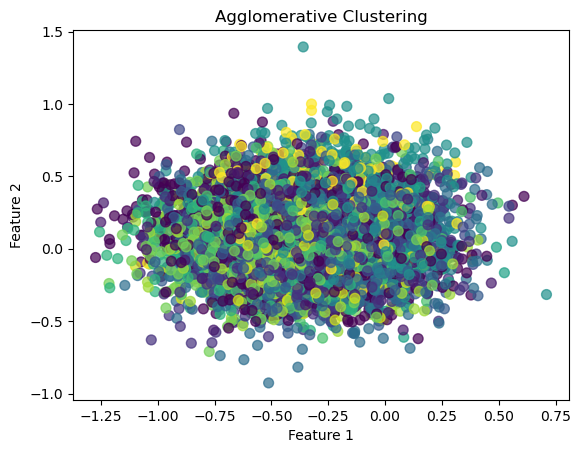

In [244]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=15)
clustering.fit(sampled_embeddings)

# Plot the clustered data
plt.scatter(sampled_embeddings[:, 0], sampled_embeddings[:, 1], c=clustering.labels_, cmap='viridis', s=50, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()